In [14]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/08 13:58
# @Author  : Wang Yujia
# @File    : PT_demo.ipynb

# @Description : 1. 用SA试做一下inference of PT model's 3 params

# 1. Preparations
## 1.1 Import

In [1]:

import numpy as np
import pandas as pd
import sympy
import time
import datetime
from sko.tools import set_run_mode
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sko.SA import SABoltzmann
#from SA_PT import SABoltzmann as SABoltzmann
import multiprocessing
from multiprocessing.dummy import Pool

## 1.2 Global Settings

In [14]:
# auction settings from Swoopo
#b = 0.75
#v = 169.99
#d = 0.15

# auction settings from paper's Fig.1 left
b= 0.75
v = 49.99
d = 0.15

# cnt_row = data_i.shape[0]
cnt_row = 5
# cnt_n_2 = data_i['cnt_n_2']
cnt_n_2 = [1,1,2,3,1]
#N_i = data_i['N']
N_i = [500,50,100,200,300]
# max duration from Swoopo
max_T = 831

# from paper's Table 5 'All auction'
alpha = 0.025
delta = 1
labda = 3.72

# initial params
# table_5_M = [0.025,0.85,3.72]
table_5_M = [0.025,3.72]

# lower/ upper bound
lb = [-0.3,0.01,0.01]
ub = [0.3, 2, 16]

# paper setting
#T = int((v-b)/d)

# 2. Infer with SA
1. 用SA 求解参数。
2. 定义函数之后，求一个uniq auction下的u和p
3. 然后用p求NLL作为最终的loss

## 2.1 function definition
1. 根据Eq(7)-(9)

In [4]:
def C(t,b):
    return 0.2*t*b

def OMEGA(p,delta):
    return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))

# valuation function
def f(x, alpha):
    #return (1-sympy.E**(-alpha*x))/alpha
    return (1-np.exp(-alpha*x))/alpha
    # when x < 0, in fact, it shoule be : (-labda)*(1-sympy.E**(alpha*x))/alpha

def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
    func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

    if(tmp >= 0):
        return sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
    else:
        return sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)

## 2.2 Loss func
1. 这个函数比较长 没办法，求u需要用SA给的params的值。`loss_func`的返回值是NLL
2. 求解`U_i[t]` which is a array with shape of (max(N)),`U_i[t]`就是paper里的`p_t`
3. for different auction, the duration is N_i[idx] and the value of duration it is various
4. nll计算时乘的`cnt_n_2[idx]`是为了减少计算次数，表示duration相同的auction的数量。

In [23]:
def loss_func(params):

    start_time = datetime.datetime.now()

    alpha,delta,labda = params

    # solve for U from Equi. condt.
    U_i = [0] * (max_T + 1)
    U_i[0] = 1

    for t in range(1,max_T+1):
        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)

    # calculate NLL under this auction setting & PT params
    nll = 0
    if(U_i[0]==1):
        U_i.pop(0)       # because U_i[0]=1

    print("log test before: ",np.log(min(U_i)))
    U_i_sorted = np.sort(np.unique(U_i))
    U_i[U_i[U_i == 0.0]] = U_i_sorted[1]
    print("log test before: ",np.log(min(U_i)))

    U_tmp_df = pd.DataFrame(U_i, index=np.arange(0, U_i.__len__()), columns=['U'], dtype=float)
    # cnt_row = data_i.shape[0]
    for idx in range(0,cnt_row):
        # sum up the log prob among all durations of this auction
        nll += ( np.sum(U_tmp_df[0:(N_i[idx]-1)][:].apply(np.log,axis=1)) + np.log(1-U_tmp_df.iat[(N_i[idx]-1),0]) )* cnt_n_2[idx]

    print('loss_func costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time).total_seconds()))
    return float(-nll)

In [6]:
# for SA testing
def demo_func(x,settings):
    alpha = x[0]
    delta = x[1]
    labda = x[2]

    v,d,b = settings[0], settings[1], settings[2]

    print("what the settings: ",v,d,b)
    return alpha ** 2 + (labda - 0.05) ** 2 + delta ** 2

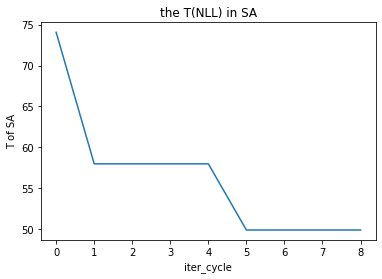

best x:  [-0.29344945  0.45054186  7.72721328]
best y:  49.91387101249883


In [17]:
# # draw and print
# plt.title("the T(NLL) in SA")
# plt.xlabel("iter_cycle")
# plt.ylabel("T of SA")
# sns.lineplot(x = np.arange(0,sa_boltzmann.iter_cycle+1),y=np.array(sa_boltzmann.generation_best_Y))
# plt.show()
# print("best x: ",sa_boltzmann.best_x)
# print("best y: ",sa_boltzmann.best_y)

#3. calculate P
1. infer结束后可以用param计算P，
2. 方法无非是先算u再算p,然后把p对应着key输出到字典里

In [ ]:
alpha = 0.025
delta = 1
labda = 3.72

# solve for U&P from Equi. condt.
U_i = [0] * (max_T + 1)
U_i[0] = 1
P_tmp = [0]*(max_T+1)   # P is what we want to generate
P_tmp[0] = 1

tmp = 1

for t in range(1,max_T+1):

    U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
    P_tmp[t] = (1- U_i[t])*tmp
    tmp = tmp*U_i[t]

# 4. 解方程方法的比较

## 4.1 scipy
1. 需要把求解的方程定义成函数

In [26]:
from scipy.optimize import fsolve
ans_scipy=[]
def func_1(u,*args):
    alpha,delta,labda,t,b,tmp = args
    return (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))

def func_2(u,*args):
    alpha,delta,labda,t,b,tmp = args
    return (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

for t in range(1,max_T+1):
    tmp = v-d*t-C(t-1,b) - b
    if(tmp >= 0):
        root = fsolve(func_1,np.zeros(1),args =(alpha,delta,labda,t,b,tmp))
        #print(f"t:{t} ---- u:{root}")
        ans_scipy.append(root)
    else:
        root = fsolve(func_2,np.zeros(1),args =(alpha,delta,labda,t,b,tmp))
        #print(f"t:{t} -- u:{root}")
        ans_scipy.append(root)

D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
D:\Anaconda\envs\pythorch\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [31]:
print("log test before: ",np.log(min(ans_scipy)))
ans_scipy_sorted = np.unique(ans_scipy)
print(np.where(ans_scipy == 0.0)[0])
ans_scipy[np.where(ans_scipy == 0.0)[0]] = ans_scipy_sorted[1]
print("log test before: ",np.log(min(ans_scipy)))


ans_scipy_df = pd.DataFrame(ans_scipy,columns=['u'])
ans_scipy_df['t'] = np.arange(0,len(ans_scipy)).T
#pic = sns.relplot(x = ans_scipy_df['t'], y = ans_scipy_df['u'], kind="line")

log test before:  [-inf]
[]


D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


TypeError: only integer scalar arrays can be converted to a scalar index

## 4.2 sympy

In [22]:
ans_sympy=[]
for t in range(1,max_T+1):
    tmp = v-d*t-C(t-1,b) - b
    u = sympy.Symbol('u')

    if(tmp >= 0):
        func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
        root =  sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
        #print(f"t:{t} ---- u:{root}")
        ans_sympy.append(np.array(root,dtype=float))
    else:
        func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))
        root =  sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)
        #print(f"t:{t} -- u:{root}")
        ans_sympy.append(np.array(root,dtype=float))
print("DONE")

DONE
5.421010862427522e-20


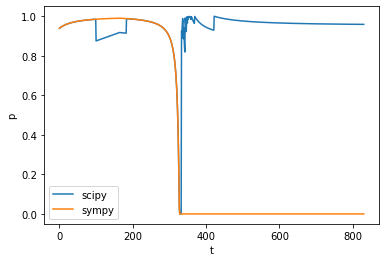

In [18]:
print(min(ans_sympy))    # 5.421010862427522e-20
ans_scipy_df['u2'] = np.array(ans_sympy)

plt.xlabel("t")
plt.ylabel("p")
plt.plot(ans_scipy_df.t, ans_scipy_df.u)
plt.plot(ans_scipy_df.t, ans_scipy_df.u2)
plt.legend(labels=['scipy','sympy'])
plt.show()